In [1]:
%matplotlib inline
from matplotlib import pyplot
import sys
sys.path.insert(0,'/home/ernie/caffe2/build')

from caffe2.python import core, model_helper, net_drawer, workspace, brew
import caffe2.python.models.VGGNet as VGGNet
import numpy as np

In [2]:
def AddInput(model,batch_size,db,db_type):
    data, label = brew.image_input(
        model, [],["data","label"],batch_size=batch_size,
        use_caffe_datum=True,
        crop=32,
        scale=40,
        db=db,db_type=db_type
    )
    return data, label

In [3]:
def AddModel(model,data):
    fc7 = VGGNet.VGGNetBody(model,data,3,dropout=False,dilated=True)
    fc8 = brew.fc(model,fc7,'fc8',4096,10)
    softmax = brew.softmax(model,fc8,'softmax')
    return softmax

In [4]:
def AddAccuracy(model, softmax, label):
    accuracy = brew.accuracy(model, [softmax,label],"accuracy")
    return accuracy

In [5]:
def AddTrainingOperators(model, softmax, label):
    xent = model.LabelCrossEntropy([softmax,label],'xent')
    loss = model.AveragedLoss(xent,'loss')
    AddAccuracy(model,softmax,label)
    model.AddGradientOperators([loss])
    ITER = brew.iter(model,"iter")
    LR = model.LearningRate(ITER,"LR",base_lr=-0.001,policy="step",stepsize=1000,gamma=0.1)
    ONE = model.param_init_net.ConstantFill([],"ONE", shape=[1],value=1.0)
    for param in model.params:
        param_grad = model.param_to_grad[param]
        model.WeightedSum([param,ONE,param_grad,LR],param)
    

In [6]:
arg_scope = {"order":"NCHW"}
train_model = model_helper.ModelHelper(name="cifar10_train",arg_scope=arg_scope)
data, label = AddInput(train_model, batch_size=10,
                      db="/home/ernie/data/cifar10/cifar10_train_lmdb",db_type='lmdb')
softmax = AddModel(train_model, data)
AddTrainingOperators(train_model, softmax, label)

arg_scope = {"order":"NCHW"}
test_model = model_helper.ModelHelper(name="cifar10_train",arg_scope=arg_scope)
data, label = AddInput(test_model, batch_size=100,
                      db="/home/ernie/data/cifar10/cifar10_test_lmdb",db_type='lmdb')
softmax = AddModel(test_model, data)
AddAccuracy(train_model, softmax, label)


0
100
200
300
400
500
600
700
800
900
1000
1100
1200
1300
1400
1500
1600
1700
1800
1900
2000
2100
2200
2300
2400
2500
2600
2700
2800
2900
3000
3100
3200
3300
3400
3500
3600
3700
3800
3900
4000
4100
4200
4300
4400
4500
4600
4700
4800
4900


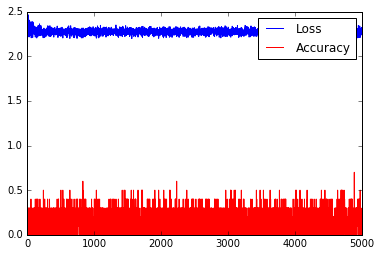

In [7]:
workspace.RunNetOnce(train_model.param_init_net)
workspace.CreateNet(train_model.net, overwrite=True)
total_iters = 5000
accuracy = np.zeros(total_iters)
loss = np.zeros(total_iters)
# Now, we will manually run the network for 200 iterations.
for i in range(total_iters):
    workspace.RunNet(train_model.net)
    accuracy[i] = workspace.FetchBlob('accuracy')
    loss[i] = workspace.FetchBlob('loss')
    if i % 100==0:
        print i
pyplot.plot(loss, 'b')
pyplot.plot(accuracy, 'r')
pyplot.legend(('Loss', 'Accuracy'), loc='upper right')

In [8]:
print accuracy[329]

0.20000000298
